## ART Before and After Traffic Impact Analysis

The following is an analysis of traffic count data in Albuquerque, NM, focusing on the area of Central AVE. that hosts the Albuquerque Rapit Transit (ART) dedicated bus lane - between Coors Blvd. and Louisiana Blvd. We will look at traffic impacts along Central, but also how parallel routes like Lead, Coal, and Lomas were impacted. This analysis will focus on the eastside of the river where there are more logical parallel corridors where traffic could displace to. Also, the lane configuration, for the most part, was unchanged west of the Rio Grande. Central Avenue had 4 general purpose lanes before ART west of the river, and after ART, all four general purpose lanes were preserved.

In [1]:
import pathlib 
NOTEBOOK_PATH = pathlib.Path().resolve()
DATA_DIRECTORY = NOTEBOOK_PATH / "data"
OUTPUT_DIRECTORY = NOTEBOOK_PATH / "docs"

In [2]:
import pandas as pd
import geopandas as gpd

data = gpd.read_file("data/TAQA_Data/mjr_rds_2023.gpkg")

In [3]:
# Let's check the roadway data head
data.head()

,OBJECTID,MRTNI_Func,MRTNIcogid,ONE_WAY,COGID,RTE,LOCAT,LENGTH,MILES,ADT22,...,ADT02,AWDT02,ADT01,AWDT01,ADT00,AWDT00,Shape_Length,ADT23,AWDT23,geometry
0,1,8,1998,E,NaN,None,None,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,954.968271,NaN,NaN,"MULTILINESTRING ((1537901.27281 1518885.41196,..."
1,2,4,1999,B,NaN,None,NORTH OF MEADE - SOUTH OF CONDERSHIRE,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,841.849864,NaN,NaN,"MULTILINESTRING ((1497526.51531 1463666.51518,..."
2,3,2,10003,B,10003.0,UNSER BLVD.,NORTH OF NORTHERN - SOUTH OF 15TH AVE.,2106.069,0.399,22160.0,...,11133.0,11633.0,10829.0,11316.0,10412.0,10880.0,2106.068785,21852.0,23529.0,"MULTILINESTRING ((1507058.99985 1555528.75009,..."
3,4,2,10004,B,10004.0,N.M. 528,NORTH OF CORRALES RD. (NM 448) - .118 MILES N...,648.945,0.123,25188.0,...,25340.0,26479.0,20742.0,21674.0,19942.0,20838.0,669.271899,25134.0,26844.0,"MULTILINESTRING ((1530760.33729 1555735.63912,..."
4,5,4,10005,B,10005.0,GRANDE VISTA,NORTH OF CORRALES RD. - SOUTH OF SANDIA VISTA,1070.855,0.203,2087.0,...,2100.0,2225.0,1792.0,1898.0,1723.0,1825.0,1033.030125,2058.0,2301.0,"MULTILINESTRING ((1531922.80708 1555068.59616,..."


In [4]:
# and let's check the roadway data shape - how many rows/columns
data.shape

(3050, 65)

In [5]:
# Let's see what the column names for the roadway data are:
data.columns

Index(['OBJECTID', 'MRTNI_Func', 'MRTNIcogid', 'ONE_WAY', 'COGID', 'RTE',
       'LOCAT', 'LENGTH', 'MILES', 'ADT22', 'AWDT22', 'flag22', 'ADT21',
       'AWDT21', 'flag21', 'ADT20', 'AWDT20', 'flag20', 'ADT19', 'AWDT19',
       'flag19', 'ADT18', 'AWDT18', 'flag18', 'ADT17', 'AWDT17', 'flag17',
       'ADT16', 'AWDT16', 'ADT15', 'AWDT15', 'ADT14', 'AWDT14', 'ADT13',
       'AWDT13', 'ADT12', 'AWDT12', 'ADT11', 'AWDT11', 'ADT10', 'AWDT10',
       'ADT09', 'AWDT09', 'ADT08', 'AWDT08', 'ADT07', 'AWDT07', 'ADT06',
       'AWDT06', 'ADT05', 'AWDT05', 'ADT04', 'AWDT04', 'ADT03', 'AWDT03',
       'ADT02', 'AWDT02', 'ADT01', 'AWDT01', 'ADT00', 'AWDT00', 'Shape_Length',
       'ADT23', 'AWDT23', 'geometry'],
      dtype='object')

In [6]:
type(data)

geopandas.geodataframe.GeoDataFrame

### Road data looks good:

We have a geo-dataframe with historical traffic counts going back to 2000. Let's create fields to represent the average traffic in the 5 years before ART and the 5 years after ART to see if there was a significant change along the ART corridor. We will be able to hone in on the parallel routes like Lead/Coal as well as Lomas and even Bridge BLVD and I-40. We can see if traffic spiked on these corridors more so than it did in the region as a whole. 

so first, let's create fields that represent the average of the pre-ART yeaers and the post-ART yeaers

In [7]:
# create variables to store fields representing the 5 years pre and post ART
# Note, the construciton year - 2017 - was left out of the data
# I am going to add two levels of analyis - 2 year and 5 year. we will average ADT data 
# for the pre and post ART period a the 2 and 5 year aggregation. 
# I wanted to use 5 year as we will get a better idea of the impact as we have more counts
# 2 year will allow us to avoid the COVID era. 2018 was the tail end of construction, but
# the traffic patterns should have solidified by then. 
# 2017 was a full construction year, so we are leaving that out of the dataset

import numpy as np

PRE_ART_2_YEAR = ['ADT15', 'ADT16']
POST_ART_2_YEAR = ['ADT18', 'ADT19']

PRE_ART_5_YEAR = ['ADT12', 'ADT13', 'ADT14', 'ADT15', 'ADT16']
POST_ART_5_YEAR = ['ADT18', 'ADT19', 'ADT20', 'ADT21', 'ADT22']

# Calculate means across years (ignoring NaNs)
data['PRE_ART_2_YEAR_MEAN'] = data[PRE_ART_2_YEAR].mean(axis=1)
data['POST_ART_2_YEAR_MEAN'] = data[POST_ART_2_YEAR].mean(axis=1)

data['PRE_ART_5_YEAR_MEAN'] = data[PRE_ART_5_YEAR].mean(axis=1)
data['POST_ART_5_YEAR_MEAN'] = data[POST_ART_5_YEAR].mean(axis=1)

# Let's make a field for the percentage change between pre/post ART years for whole dataset
data['PCT_CHANGE_2_YR'] = ((data['POST_ART_2_YEAR_MEAN'] - data['PRE_ART_2_YEAR_MEAN']) / data['PRE_ART_2_YEAR_MEAN']) * 100
data['PCT_CHANGE_5_YR'] = ((data['POST_ART_5_YEAR_MEAN'] - data['PRE_ART_5_YEAR_MEAN']) / data['PRE_ART_5_YEAR_MEAN']) * 100

# Absolute change fields (pre - post) - this will help us see if traffic "disappeared" or not
data['ABS_CHANGE_2_YR'] = data['POST_ART_2_YEAR_MEAN'] - data['PRE_ART_2_YEAR_MEAN']
data['ABS_CHANGE_5_YR'] = data['POST_ART_5_YEAR_MEAN'] - data['PRE_ART_5_YEAR_MEAN']

# Let's format the numbers nicely for charts and what not
data['ABS_2_YR_CLEAN'] = data['ABS_CHANGE_2_YR'].round(0)
data['ABS_5_YR_CLEAN'] = data['ABS_CHANGE_5_YR'].round(0)

# Replace infinite values with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Create clean rounded columns for mapping/labels
data['PCT_2_YR_CLEAN'] = data['PCT_CHANGE_2_YR'].round(2)
data['PCT_5_YR_CLEAN'] = data['PCT_CHANGE_5_YR'].round(2)
data.columns

Index(['OBJECTID', 'MRTNI_Func', 'MRTNIcogid', 'ONE_WAY', 'COGID', 'RTE',
       'LOCAT', 'LENGTH', 'MILES', 'ADT22', 'AWDT22', 'flag22', 'ADT21',
       'AWDT21', 'flag21', 'ADT20', 'AWDT20', 'flag20', 'ADT19', 'AWDT19',
       'flag19', 'ADT18', 'AWDT18', 'flag18', 'ADT17', 'AWDT17', 'flag17',
       'ADT16', 'AWDT16', 'ADT15', 'AWDT15', 'ADT14', 'AWDT14', 'ADT13',
       'AWDT13', 'ADT12', 'AWDT12', 'ADT11', 'AWDT11', 'ADT10', 'AWDT10',
       'ADT09', 'AWDT09', 'ADT08', 'AWDT08', 'ADT07', 'AWDT07', 'ADT06',
       'AWDT06', 'ADT05', 'AWDT05', 'ADT04', 'AWDT04', 'ADT03', 'AWDT03',
       'ADT02', 'AWDT02', 'ADT01', 'AWDT01', 'ADT00', 'AWDT00', 'Shape_Length',
       'ADT23', 'AWDT23', 'geometry', 'PRE_ART_2_YEAR_MEAN',
       'POST_ART_2_YEAR_MEAN', 'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN',
       'PCT_CHANGE_2_YR', 'PCT_CHANGE_5_YR', 'ABS_CHANGE_2_YR',
       'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN', 'ABS_5_YR_CLEAN', 'PCT_2_YR_CLEAN',
       'PCT_5_YR_CLEAN'],
      dtype='object'

In [8]:
data.dtypes

OBJECTID             int64
MRTNI_Func          object
MRTNIcogid           int32
ONE_WAY             object
COGID              float64
                    ...   
ABS_CHANGE_5_YR    float64
ABS_2_YR_CLEAN     float64
ABS_5_YR_CLEAN     float64
PCT_2_YR_CLEAN     float64
PCT_5_YR_CLEAN     float64
Length: 77, dtype: object

In [9]:
data['COGID'].head()

0        NaN
1        NaN
2    10003.0
3    10004.0
4    10005.0
Name: COGID, dtype: float64

In [10]:
# I created two spredsheets that are selections of the relevant links that represent
# Central along the ART dedicated lane stretch (Coors to Louisina), and the art_adj_links 
# represent the ART Adjacent Links - all of Lead/Coal + Zuni until Louisiana 
# and Lomas from San Pasquale to Louisiana
import pandas as pd

art_links = pd.read_csv('data/ART_Links.csv')
art_adj_links = pd.read_csv('data/ART_ADJ_FLAG.csv')
art_links.head()

,COGID,RTE,LOCAT
0,23884,CENTRAL,EAST OF RIO GRANDE BLVD. - WEST OF LOMAS
1,24136,CENTRAL,EAST OF TINGLEY - WEST OF NEW YORK AVE.
2,24137,CENTRAL,EAST OF NEW YORK - WEST OF RIO GRANDE
3,24344,CENTRAL,EAST OF SUNSET - WEST OF TINGLEY
4,24420,CENTRAL,SOUTHEAST OF LOMAS - NORTHWEST OF TIJERAS


In [11]:
art_adj_links.tail()

,COGID,RTE,LOCAT
52,25708,COAL,EAST OF YALE - WEST OF GIRARD
53,25716,COAL,EAST OF UNIVERSITY - WEST OF YALE
54,25784,ZUNI,EAST OF WASHINGTON (LEAD/COAL) - WEST OF SAN M...
55,25800,ZUNI,EAST OF SAN MATEO - WEST OF SAN PEDRO
56,25820,ZUNI,EAST OF SAN PEDRO - WEST OF LOUISIANA


In [12]:
# We are having issues becuase we need to change COGID to a string but there are NA values
# we need to Drop rows with missing COGIDs before we try to join tables
data = data[data['COGID'].notna()].copy()

# Step 2: Convert to int → str
data['COGID'] = data['COGID'].astype(int).astype(str)
print(data.dtypes)

OBJECTID             int64
MRTNI_Func          object
MRTNIcogid           int32
ONE_WAY             object
COGID               object
                    ...   
ABS_CHANGE_5_YR    float64
ABS_2_YR_CLEAN     float64
ABS_5_YR_CLEAN     float64
PCT_2_YR_CLEAN     float64
PCT_5_YR_CLEAN     float64
Length: 77, dtype: object


In [13]:
# Let's make sure the COGID's are also strings in the art_links and art_adj_links 
# so that we can join them to the main dataset and be able to do analysis just on those links
# Standardize COGID format: float → int → str
art_links['COGID'] = art_links['COGID'].astype(int).astype(str)
art_adj_links['COGID'] = art_adj_links['COGID'].astype(int).astype(str)
print(art_links.dtypes)

COGID    object
RTE      object
LOCAT    object
dtype: object


In [14]:

# Create binary flag fields to indicate whether link is on ART corridor or an ART_Adjacent corridor
data['IS_ART'] = data['COGID'].isin(art_links['COGID']).astype(int)
data['IS_ART_ADJ'] = data['COGID'].isin(art_adj_links['COGID']).astype(int)
data.columns


Index(['OBJECTID', 'MRTNI_Func', 'MRTNIcogid', 'ONE_WAY', 'COGID', 'RTE',
       'LOCAT', 'LENGTH', 'MILES', 'ADT22', 'AWDT22', 'flag22', 'ADT21',
       'AWDT21', 'flag21', 'ADT20', 'AWDT20', 'flag20', 'ADT19', 'AWDT19',
       'flag19', 'ADT18', 'AWDT18', 'flag18', 'ADT17', 'AWDT17', 'flag17',
       'ADT16', 'AWDT16', 'ADT15', 'AWDT15', 'ADT14', 'AWDT14', 'ADT13',
       'AWDT13', 'ADT12', 'AWDT12', 'ADT11', 'AWDT11', 'ADT10', 'AWDT10',
       'ADT09', 'AWDT09', 'ADT08', 'AWDT08', 'ADT07', 'AWDT07', 'ADT06',
       'AWDT06', 'ADT05', 'AWDT05', 'ADT04', 'AWDT04', 'ADT03', 'AWDT03',
       'ADT02', 'AWDT02', 'ADT01', 'AWDT01', 'ADT00', 'AWDT00', 'Shape_Length',
       'ADT23', 'AWDT23', 'geometry', 'PRE_ART_2_YEAR_MEAN',
       'POST_ART_2_YEAR_MEAN', 'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN',
       'PCT_CHANGE_2_YR', 'PCT_CHANGE_5_YR', 'ABS_CHANGE_2_YR',
       'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN', 'ABS_5_YR_CLEAN', 'PCT_2_YR_CLEAN',
       'PCT_5_YR_CLEAN', 'IS_ART', 'IS_ART_ADJ

OK, everything looks good so far - now we have two fields in the main dataset that tell us wether a link is in the ART study area or on a roadway we consdier "ART Adjacent" and likely to receive spillover traffic if that is what happened. 

In [15]:
# Keep full dataset for analysis
full_data = data.copy()

import geopandas as gpd

# Recreate map_data with geometry
map_data = gpd.GeoDataFrame(
    data[['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN',
          'POST_ART_2_YEAR_MEAN', 'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN',
          'PCT_CHANGE_2_YR', 'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN',
          'PCT_5_YR_CLEAN', 'IS_ART', 'IS_ART_ADJ','ABS_CHANGE_2_YR',
       'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN', 'ABS_5_YR_CLEAN', 'geometry']],
    crs=data.crs  # preserve original CRS
)
map_data.shape

(3048, 18)

In [16]:
map_data.dtypes

COGID                     object
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
geometry                geometry
dtype: object

In [17]:
# We do have a bit of missing data, but I doubt there will be missing data on the ART
# and ART adjacent links
print(map_data['PCT_2_YR_CLEAN'].isna().sum())
print(map_data['PCT_5_YR_CLEAN'].isna().sum())

137
131


In [18]:
print(map_data['PRE_ART_2_YEAR_MEAN'].mean().round(2))
print(map_data['POST_ART_2_YEAR_MEAN'].mean().round(2))

11675.27
12623.84


In [19]:
print(type(map_data))
print(map_data.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
GEOGCS["Undefined geographic SRS",DATUM["unknown",SPHEROID["unknown",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST]]


In [20]:
# We need to set the CRS before we can reproject it to a web-friendly projection
map_data.set_crs(epsg=6529, inplace=True, allow_override=True)

print(map_data.total_bounds)


[1277984.37236941 1186639.21687807 1928138.916874   1900771.46872883]


In [21]:
#Re-projecting to this crs should make for easier web-mapping
map_data = map_data.to_crs(epsg=4326)
print(map_data.total_bounds)

[-107.4786898    34.26004973 -105.28934893   36.21760708]


In [22]:
map_data.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# Save the cleaned GeoDataFrame to a new GeoPackage
# map_data.to_file(
#     OUTPUT_DIRECTORY / "traffic_change_analysis.gpkg",
#     layer="traffic_pct_change",
#     driver="GPKG"
# )
# I'm going to leave this commented out so I don't accidentally re-create a new traffic_change_analysis gpkg

In [23]:
import geopandas as gpd

# Re-import the updated GeoPackage
updated_data = gpd.read_file("docs/traffic_change_analysis.gpkg", layer="traffic_pct_change")

# Confirm the new fields are there
print(updated_data.columns)


Index(['COGID', 'RTE', 'LOCAT', 'PRE_ART_2_YEAR_MEAN', 'POST_ART_2_YEAR_MEAN',
       'PRE_ART_5_YEAR_MEAN', 'POST_ART_5_YEAR_MEAN', 'PCT_CHANGE_2_YR',
       'PCT_CHANGE_5_YR', 'PCT_2_YR_CLEAN', 'PCT_5_YR_CLEAN', 'IS_ART',
       'IS_ART_ADJ', 'ABS_CHANGE_2_YR', 'ABS_CHANGE_5_YR', 'ABS_2_YR_CLEAN',
       'ABS_5_YR_CLEAN', 'geometry'],
      dtype='object')


In [24]:
# We can make a selection of just the ART links
updated_data[updated_data['IS_ART'] == 1].head()

,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,PCT_5_YR_CLEAN,IS_ART,IS_ART_ADJ,ABS_CHANGE_2_YR,ABS_CHANGE_5_YR,ABS_2_YR_CLEAN,ABS_5_YR_CLEAN,geometry
1530,23884,CENTRAL,EAST OF RIO GRANDE BLVD. - WEST OF LOMAS,26902.5,23544.0,25548.6,19560.2,-12.483970,-23.439249,-12.48,-23.44,1,0,-3358.5,-5988.4,-3358.0,-5988.0,"MULTILINESTRING ((-106.67142 35.09515, -106.67..."
1576,24136,CENTRAL,EAST OF TINGLEY - WEST OF NEW YORK AVE.,33598.5,25920.0,31815.0,23830.0,-22.853699,-25.098224,-22.85,-25.10,1,0,-7678.5,-7985.0,-7678.0,-7985.0,"MULTILINESTRING ((-106.67919 35.09107, -106.67..."
1577,24137,CENTRAL,EAST OF NEW YORK - WEST OF RIO GRANDE,31270.0,28967.0,30397.8,24955.8,-7.364886,-17.902611,-7.36,-17.90,1,0,-2303.0,-5442.0,-2303.0,-5442.0,"MULTILINESTRING ((-106.6775 35.09436, -106.677..."
1602,24344,CENTRAL,EAST OF SUNSET - WEST OF TINGLEY,37237.0,25653.0,34254.4,26030.2,-31.108843,-24.009178,-31.11,-24.01,1,0,-11584.0,-8224.2,-11584.0,-8224.0,"MULTILINESTRING ((-106.68279 35.08716, -106.68..."
1618,24420,CENTRAL,SOUTHEAST OF LOMAS - NORTHWEST OF TIJERAS,14170.5,13450.5,12716.6,10266.8,-5.080978,-19.264583,-5.08,-19.26,1,0,-720.0,-2449.8,-720.0,-2450.0,"MULTILINESTRING ((-106.66877 35.09365, -106.66..."


In [25]:
updated_data[updated_data['IS_ART'] == 1].shape

(38, 18)

In [26]:
# Mean percent change on ART corridor links
art_pct_mean = updated_data[updated_data['IS_ART'] == 1]['PCT_2_YR_CLEAN'].mean()
print("Mean PCT_CHANGE on ART corridor:", round(art_pct_mean, 2))


Mean PCT_CHANGE on ART corridor: -15.02


In [27]:
# Summary statistics
art_stats = updated_data[updated_data['IS_ART'] == 1]['PCT_2_YR_CLEAN'].describe()
print(art_stats)


count    38.000000
mean    -15.023421
std      15.194309
min     -53.400000
25%     -24.465000
50%     -13.300000
75%      -4.652500
max      10.180000
Name: PCT_2_YR_CLEAN, dtype: float64


In [28]:
# Let's check the percent change on ART Adjacent corirdors for the 2 year time period:
art_adj_mean = updated_data[updated_data['IS_ART_ADJ'] == 1]['PCT_2_YR_CLEAN'].mean().round(2)
print("Mean PCT_CHANGE on ART adjacent corridors (Lead/Coal/Lomas:", art_adj_mean)

Mean PCT_CHANGE on ART adjacent corridors (Lead/Coal/Lomas: 2.65


In [29]:
art_adj_stats = updated_data[updated_data['IS_ART_ADJ'] == 1]['PCT_2_YR_CLEAN'].describe()
print(art_adj_stats)

count    57.000000
mean      2.648947
std      19.120505
min     -44.790000
25%      -7.670000
50%       6.160000
75%      10.850000
max      64.670000
Name: PCT_2_YR_CLEAN, dtype: float64


In [30]:
rest_of_net_mean_2yr = updated_data[
    (updated_data['IS_ART'] != 1) & (updated_data['IS_ART_ADJ'] != 1)
]['PCT_2_YR_CLEAN'].mean().round(2)
print("Mean PCT_CHANGE on the rest of the network excluding ART and ART adjacent links is:", rest_of_net_mean_2yr) 

Mean PCT_CHANGE on the rest of the network excluding ART and ART adjacent links is: 17.0


In [31]:
rest_of_net = updated_data[(updated_data['IS_ART'] != 1) & (updated_data['IS_ART_ADJ'] != 1)].describe()
print(rest_of_net)

       PRE_ART_2_YEAR_MEAN  POST_ART_2_YEAR_MEAN  PRE_ART_5_YEAR_MEAN  \
count          2952.000000           2900.000000          2952.000000   
mean          11605.035400          12620.839655         11287.166531   
std           14805.885942          15330.225853         14456.545841   
min               0.000000             39.000000             0.000000   
25%            1855.375000           2486.750000          1769.700000   
50%            6452.250000           7301.500000          6185.600000   
75%           15791.125000          16985.375000         15173.000000   
max           97314.000000         101683.000000         93082.200000   

       POST_ART_5_YEAR_MEAN  PCT_CHANGE_2_YR  PCT_CHANGE_5_YR  PCT_2_YR_CLEAN  \
count           2904.000000      2816.000000      2822.000000     2816.000000   
mean           11783.183953        17.001805        21.395000       17.001836   
std            14471.207647        66.809066       103.879829       66.809127   
min               

In [32]:
# I want to limit the rest of network just to BernCO 
# I think the fast growing roads in valencia and Sandoval are skewing the data
import geopandas as gpd

# Step 1: Load Bernalillo County dissolved boundary
bernco = gpd.read_file("data/NM_Census_Shp/BernCO_Dissolved.gpkg")
bernco = bernco.to_crs(updated_data.crs)  # Ensure CRS matches

print(bernco.crs)

EPSG:4326


In [33]:
bernco_data = gpd.sjoin(updated_data, bernco, how="inner", predicate="within")
bernco_data.shape

(2029, 21)

In [34]:
bernco_data["IS_ART"].value_counts()


IS_ART
0    1991
1      38
Name: count, dtype: int64

In [35]:
bernco_data["IS_ART_ADJ"].value_counts()

IS_ART_ADJ
0    1972
1      57
Name: count, dtype: int64

## Volume-Weighted Percent Change by Corridor (Bernalillo County Only)

This updated table calculates the percent change in traffic volume by summing all pre- and post-ART ADT values within each corridor category, rather than averaging percent changes at the segment level.

Unlike the earlier approach, this method:
- Weighs each roadway segment by its actual traffic volume
- Avoids distortion from low-volume roads with large relative swings
- Restricts analysis to Bernalillo County to align with ART’s geographic context

This provides a more accurate reflection of total network impact by corridor.


### Let's look at this in more detail 

here is a table that shows a fictional portion of the study area with fake numbers just to illustrate the point.

| Segment     | Before ADT | After ADT | % Change |
| ----------- | ---------- | --------- | -------- |
| Central Ave | 9,000      | 4,500     | -50%     |
| Lomas Blvd  | 10,000     | 12,000    | +20%     |
| Lead/Coal   | 500        | 1,000     | +100%    |

If we simply average the percent changes, we get:

    (-50% + 20% + 100%) / 3 = +23.3%

This suggests a net increase in traffic — but it’s highly misleading, since the 500 ADT segment is given equal weight to much busier roads.

Instead, if we calculate the total volume change:

    Total Before = 9,000 + 10,000 + 500 = 19,500

    Total After = 4,500 + 12,000 + 1,000 = 17,500

    Net Change = -2,000 → -10.3%

This gives a much truer picture: total traffic across the area decreased, despite small corridors showing big relative gains.


In [36]:
import pandas as pd

# Helper function to calculate volume-weighted percent change
def pct_change(df, pre_col, post_col):
    pre = df[pre_col].sum()
    post = df[post_col].sum()
    return round(((post - pre) / pre) * 100, 2)

# Segment filters
art_links = bernco_data[bernco_data["IS_ART"] == 1]
adjacent_links = bernco_data[bernco_data["IS_ART_ADJ"] == 1]
rest_of_network = bernco_data[
    (bernco_data["IS_ART"] != 1) & (bernco_data["IS_ART_ADJ"] != 1)
]

# Create summary table
summary_table = pd.DataFrame({
    "Corridor": ["ART Corridor", "ART Adjacent", "Rest of Network"],
    "Percent Change (2-Year)": [
        pct_change(art_links, "PRE_ART_2_YEAR_MEAN", "POST_ART_2_YEAR_MEAN"),
        pct_change(adjacent_links, "PRE_ART_2_YEAR_MEAN", "POST_ART_2_YEAR_MEAN"),
        pct_change(rest_of_network, "PRE_ART_2_YEAR_MEAN", "POST_ART_2_YEAR_MEAN"),
    ],
    "Percent Change (5-Year)": [
        pct_change(art_links, "PRE_ART_5_YEAR_MEAN", "POST_ART_5_YEAR_MEAN"),
        pct_change(adjacent_links, "PRE_ART_5_YEAR_MEAN", "POST_ART_5_YEAR_MEAN"),
        pct_change(rest_of_network, "PRE_ART_5_YEAR_MEAN", "POST_ART_5_YEAR_MEAN"),
    ]
})

summary_table


,Corridor,Percent Change (2-Year),Percent Change (5-Year)
0,ART Corridor,-14.47,-25.90
1,ART Adjacent,-3.06,-7.26
2,Rest of Network,4.84,0.49


## VMT update

I want to update the early AADT tables to VMT. VMT is the correct metric to use in this case, so I just want to use it and not confuse the reader with AADT and VMT - we are just going to use VMT for clarity

In [37]:
import geopandas as gpd

vmt = gpd.read_file("ART_VMT_FINAL.gpkg")
vmt.shape

(3057, 31)

In [38]:
vmt.head()

,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,...,IS_LOMAS,VMT_CHANGE_2_YR,VMT_CHANGE_5_YR,PRE_VMT_2_YR,POST_VMT_2_YR,VMT_PCT_CHANGE_2_YR,PRE_VMT_5_YR,POST_VMT_5_YR,VMT_PCT_CHANGE_5_YR,geometry
0,10003,UNSER BLVD.,NORTH OF NORTHERN - SOUTH OF 15TH AVE.,23542.0,24358.0,23399.4,22251.0,3.466146,-4.907818,3.47,...,0,325.583991,-458.051987,9393.257742,9718.841733,3.466146,9336.360343,8878.148756,-4.907818,"MULTILINESTRING ((-106.69681 35.27459, -106.69..."
1,10004,N.M. 528,NORTH OF CORRALES RD. (NM 448) - .118 MILES N...,28275.5,27846.0,24567.4,25606.2,-1.518983,4.228368,-1.52,...,0,-52.890001,127.797004,3477.886596,3425.058095,-1.518983,3021.790283,3149.562687,4.228368,"MULTILINESTRING ((-106.6174 35.27542, -106.615..."
2,10005,GRANDE VISTA,NORTH OF CORRALES RD. - SOUTH OF SANDIA VISTA,1960.0,2205.0,2195.8,2062.0,12.500000,-6.093451,12.50,...,0,49.734999,-27.201999,397.879989,447.614987,12.500000,445.747387,418.585988,-6.093451,"MULTILINESTRING ((-106.6135 35.2736, -106.6131..."
3,10006,GRANDE VISTA,NORTH OF SANDIA VISTA - S.E. OF N.M. 528,966.5,1272.0,918.0,889.4,31.608898,-3.115468,31.61,...,0,181.152002,-17.168000,572.168007,753.024010,31.608898,543.456007,526.524807,-3.115468,"MULTILINESTRING ((-106.61107 35.27551, -106.61..."
4,10007,SANDIA VISTA,S.E. OF GRANDE VISTA - EAST OF N.M. 528,913.5,1577.5,838.0,1475.0,72.687466,76.014320,72.69,...,0,676.616035,649.103034,930.856549,1607.472584,72.687466,853.922045,1503.025079,76.014320,"MULTILINESTRING ((-106.61107 35.27551, -106.61..."


In [39]:
print(vmt.crs)

EPSG:4326


<Axes: >

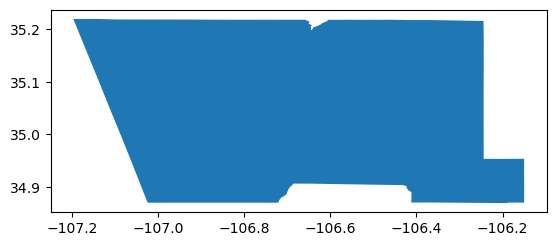

In [41]:
bernco.plot()

In [42]:
bernco_vmt = gpd.sjoin(vmt, bernco, how="inner", predicate="within")
bernco_vmt.shape

(2038, 34)

In [43]:
bernco_vmt["IS_ART"].value_counts()

IS_ART
0    1998
1      40
Name: count, dtype: int64

In [44]:
bernco_vmt[bernco_vmt["IS_ART"] == 1].tail()

,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,...,PRE_VMT_2_YR,POST_VMT_2_YR,VMT_PCT_CHANGE_2_YR,PRE_VMT_5_YR,POST_VMT_5_YR,VMT_PCT_CHANGE_5_YR,geometry,index_right,STATEFP,COUNTYFP
1849,25388,CENTRAL,EAST OF GIRARD - WEST OF CARLISLE,23016.0,15885.5,23483.2,13953.0,-30.980622,-40.583055,-30.98,...,11461.967907,7910.978936,-30.980622,11694.633505,6948.593943,-40.583055,"MULTILINESTRING ((-106.61328 35.08099, -106.61...",0,35,001
1862,25432,CENTRAL,EAST OF CARLISLE - WEST OF WASHINGTON,22375.0,17963.0,22567.6,13894.0,-19.718436,-38.433861,-19.72,...,11746.874467,9430.574572,-19.718436,11847.989462,7294.349669,-38.433861,"MULTILINESTRING ((-106.60453 35.07978, -106.60...",0,35,001
1887,25536,CENTRAL,EAST OF WASHINGTON - WEST OF SAN MATEO,23734.5,19439.0,24096.6,15220.4,-18.098127,-36.835902,-18.10,...,12413.143545,10166.597037,-18.098127,12602.521846,7960.269229,-36.835902,"MULTILINESTRING ((-106.59534 35.07876, -106.59...",0,35,001
1913,25624,CENTRAL,EAST OF SAN MATEO - WEST OF SAN PEDRO,26331.5,23065.0,25587.2,18398.4,-12.405294,-28.095298,-12.41,...,13165.750000,11532.500000,-12.405294,12793.600000,9199.200000,-28.095298,"MULTILINESTRING ((-106.58622 35.07778, -106.58...",0,35,001
1918,25652,CENTRAL,EAST OF SAN PEDRO - WEST OF LOUISIANA,25974.0,22661.5,26026.2,18800.4,-12.753138,-27.763561,-12.75,...,13142.843542,11466.718600,-12.753138,13169.256741,9513.002068,-27.763561,"MULTILINESTRING ((-106.5775 35.07685, -106.575...",0,35,001


Damn, they don't match exactly and I need to find out why

In [45]:
bernco_data_ids = set(bernco_data['COGID'])
bernco_vmt_ids = set(bernco_vmt['COGID'])


In [46]:
only_in_data = bernco_data_ids - bernco_vmt_ids
only_in_vmt = bernco_vmt_ids - bernco_data_ids

print(f"Links only in `updated_data`: {len(only_in_data)}")
print(f"Links only in `vmt`: {len(only_in_vmt)}")


Links only in `updated_data`: 1
Links only in `vmt`: 0


In [65]:
# Check for duplicate COGIDs
#bernco_data['COGID'].value_counts().value_counts()
bernco_vmt['COGID'].value_counts().value_counts()


count
1    2018
4       5
Name: count, dtype: int64

In [49]:
print("bernco_data rows:", bernco_data.shape[0])
print("bernco_data unique COGIDs:", bernco_data['COGID'].nunique())

print("bernco_vmt rows:", bernco_vmt.shape[0])
print("bernco_vmt unique COGIDs:", bernco_vmt['COGID'].nunique())


bernco_data rows: 2029
bernco_data unique COGIDs: 2024
bernco_vmt rows: 2038
bernco_vmt unique COGIDs: 2023


In [59]:
duplicates = bernco_vmt['COGID'].value_counts()
duplicates[duplicates > 1]


COGID
24868    4
29967    4
26600    4
29966    4
26697    4
Name: count, dtype: int64

In [69]:
bernco_vmt[bernco_vmt['COGID'] == '24868']


,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,...,PRE_VMT_2_YR,POST_VMT_2_YR,VMT_PCT_CHANGE_2_YR,PRE_VMT_5_YR,POST_VMT_5_YR,VMT_PCT_CHANGE_5_YR,geometry,index_right,STATEFP,COUNTYFP
1729,24868,COPPER,EAST OF 2ND ST. - NORTH OF CENTRAL,4057.0,4435.0,3674.0,3709.6,9.317229,0.968971,9.32,...,474.668995,518.894994,9.317229,429.857995,434.023195,0.968971,"MULTILINESTRING ((-106.64903 35.08525, -106.64...",0,35,001
1730,24868,COPPER,EAST OF 2ND ST. - NORTH OF CENTRAL,4057.0,4435.0,3674.0,3709.6,9.317229,0.968971,9.32,...,474.668995,518.894994,9.317229,429.857995,434.023195,0.968971,"MULTILINESTRING ((-106.64903 35.08525, -106.64...",0,35,001
1731,24868,COPPER,EAST OF 2ND ST. - NORTH OF CENTRAL,4057.0,4435.0,3674.0,3709.6,9.317229,0.968971,9.32,...,474.668995,518.894994,9.317229,429.857995,434.023195,0.968971,"MULTILINESTRING ((-106.64803 35.0841, -106.648...",0,35,001
1732,24868,COPPER,EAST OF 2ND ST. - NORTH OF CENTRAL,4057.0,4435.0,3674.0,3709.6,9.317229,0.968971,9.32,...,474.668995,518.894994,9.317229,429.857995,434.023195,0.968971,"MULTILINESTRING ((-106.64803 35.0841, -106.648...",0,35,001


In [70]:
bernco_vmt_cleaned = bernco_vmt.drop_duplicates(subset='COGID')


In [71]:
bernco_vmt_cleaned[bernco_vmt_cleaned['COGID'] == '24868']

,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,...,PRE_VMT_2_YR,POST_VMT_2_YR,VMT_PCT_CHANGE_2_YR,PRE_VMT_5_YR,POST_VMT_5_YR,VMT_PCT_CHANGE_5_YR,geometry,index_right,STATEFP,COUNTYFP
1729,24868,COPPER,EAST OF 2ND ST. - NORTH OF CENTRAL,4057.0,4435.0,3674.0,3709.6,9.317229,0.968971,9.32,...,474.668995,518.894994,9.317229,429.857995,434.023195,0.968971,"MULTILINESTRING ((-106.64903 35.08525, -106.64...",0,35,001


In [77]:
bernco_vmt_cleaned.dtypes

COGID                     object
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
MILES                    float64
IS_COAL                    int64
IS_LEAD                    int64
IS_ZUNI                    int64
IS_LOMAS                   int64
VMT_CHANGE_2_YR          float64
VMT_CHANGE_5_YR          float64
PRE_VMT_2_YR             float64
POST_VMT_2_YR            float64
VMT_PCT_CHANGE_2_YR      float64
PRE_VMT_5_YR             float64
POST_VMT_5_YR            float64
VMT_PCT_CHANGE_5_YR      float64
geometry  

In [87]:
import pandas as pd

art_east = pd.read_csv("data/ART_EAST.csv")
art_east.tail()

,COGID,RTE,LOCAT
24,25624,CENTRAL,EAST OF SAN MATEO - WEST OF SAN PEDRO
25,25652,CENTRAL,EAST OF SAN PEDRO - WEST OF LOUISIANA
26,25536,CENTRAL,EAST OF WASHINGTON - WEST OF SAN MATEO
27,25432,CENTRAL,EAST OF CARLISLE - WEST OF WASHINGTON
28,25388,CENTRAL,EAST OF GIRARD - WEST OF CARLISLE


In [90]:
art_east['COGID'] = art_east['COGID'].astype(str)
art_east.dtypes

COGID    object
RTE      object
LOCAT    object
dtype: object

In [89]:
bernco_vmt_cleaned. dtypes

COGID                     object
RTE                       object
LOCAT                     object
PRE_ART_2_YEAR_MEAN      float64
POST_ART_2_YEAR_MEAN     float64
PRE_ART_5_YEAR_MEAN      float64
POST_ART_5_YEAR_MEAN     float64
PCT_CHANGE_2_YR          float64
PCT_CHANGE_5_YR          float64
PCT_2_YR_CLEAN           float64
PCT_5_YR_CLEAN           float64
IS_ART                     int64
IS_ART_ADJ                 int64
ABS_CHANGE_2_YR          float64
ABS_CHANGE_5_YR          float64
ABS_2_YR_CLEAN           float64
ABS_5_YR_CLEAN           float64
MILES                    float64
IS_COAL                    int64
IS_LEAD                    int64
IS_ZUNI                    int64
IS_LOMAS                   int64
VMT_CHANGE_2_YR          float64
VMT_CHANGE_5_YR          float64
PRE_VMT_2_YR             float64
POST_VMT_2_YR            float64
VMT_PCT_CHANGE_2_YR      float64
PRE_VMT_5_YR             float64
POST_VMT_5_YR            float64
VMT_PCT_CHANGE_5_YR      float64
geometry  

In [92]:
bernco_vmt_cleaned = bernco_vmt_cleaned.copy()


In [95]:
bernco_vmt_cleaned.loc[:, 'IS_ART_EAST'] = bernco_vmt_cleaned['COGID'].isin(art_east['COGID']).astype(int)
bernco_vmt_cleaned[bernco_vmt_cleaned['IS_ART_EAST']==1].head()

,COGID,RTE,LOCAT,PRE_ART_2_YEAR_MEAN,POST_ART_2_YEAR_MEAN,PRE_ART_5_YEAR_MEAN,POST_ART_5_YEAR_MEAN,PCT_CHANGE_2_YR,PCT_CHANGE_5_YR,PCT_2_YR_CLEAN,...,POST_VMT_2_YR,VMT_PCT_CHANGE_2_YR,PRE_VMT_5_YR,POST_VMT_5_YR,VMT_PCT_CHANGE_5_YR,geometry,index_right,STATEFP,COUNTYFP,IS_ART_EAST
1618,24420,CENTRAL,SOUTHEAST OF LOMAS - NORTHWEST OF TIJERAS,14170.5,13450.5,12716.6,10266.8,-5.080978,-19.264583,-5.08,...,6510.041965,-5.080978,6154.834367,4969.131173,-19.264583,"MULTILINESTRING ((-106.66877 35.09365, -106.66...",0,35,001,1
1632,24464,CENTRAL,SOUTHEAST OF TIJERAS - NORTHWEST OF 12TH ST.,12729.0,8065.0,12169.0,6948.4,-36.640742,-42.900814,-36.64,...,1104.904956,-36.640742,1667.152933,951.930762,-42.900814,"MULTILINESTRING ((-106.66282 35.08866, -106.66...",0,35,001,1
1681,24672,COPPER,EAST OF CENTRAL - WEST OF 8TH ST.,1421.0,984.0,1769.4,852.0,-30.752991,-51.848084,-30.75,...,123.000000,-30.752991,221.175000,106.500000,-51.848084,"MULTILINESTRING ((-106.65855 35.08648, -106.65...",0,35,001,1
1682,24675,GOLD,EAST OF 3RD ST. - WEST OF 2ND ST.,3440.0,2593.5,3315.4,2246.0,-24.607558,-32.255535,-24.61,...,171.170999,-24.607558,218.816399,148.235999,-32.255535,"MULTILINESTRING ((-106.6506 35.0834, -106.6494...",0,35,001,1
1695,24720,COPPER,EAST OF 8TH ST. - WEST OF 6TH ST.,1954.0,1516.0,2067.8,1312.6,-22.415558,-36.521907,-22.42,...,209.207995,-22.415558,285.356393,181.138795,-36.521907,"MULTILINESTRING ((-106.65617 35.08617, -106.65...",0,35,001,1


In [101]:
central = bernco_vmt_cleaned[bernco_vmt_cleaned['IS_ART_EAST'] == 1]  # or IS_ART_ADJ, or the rest
art_adj = bernco_vmt_cleaned[bernco_vmt_cleaned['IS_ART_ADJ'] == 1]
coal = bernco_vmt_cleaned[bernco_vmt_cleaned['IS_COAL'] == 1]
lead = bernco_vmt_cleaned[bernco_vmt_cleaned['IS_LEAD'] == 1]
zuni = bernco_vmt_cleaned[bernco_vmt_cleaned['IS_ZUNI'] == 1]
lomas = bernco_vmt_cleaned[bernco_vmt_cleaned['IS_LOMAS'] == 1]
rest_of_bernco = bernco_vmt_cleaned[
    (bernco_vmt_cleaned['IS_ART'] == 0) & 
    (bernco_vmt_cleaned['IS_ART_ADJ'] == 0)
]

pre_total = bernco_vmt_cleaned['PRE_VMT_2_YR'].sum()
post_total = bernco_vmt_cleaned['POST_VMT_2_YR'].sum()
percent_change_2yr = ((post_total - pre_total) / pre_total) * 100

pre_total_5 = bernco_vmt_cleaned['PRE_VMT_5_YR'].sum()
post_total_5 = bernco_vmt_cleaned['POST_VMT_5_YR'].sum()
percent_change_5yr = ((post_total_5 - pre_total_5) / pre_total_5) * 100


In [97]:
#Going to try different approach

# def compute_percent_change(group, pre_col, post_col):
#     pre_total = group[pre_col].sum()
#     post_total = group[post_col].sum()
#     return ((post_total - pre_total) / pre_total) * 100

# summary = {
#     'Central': {
#         '2-Year': compute_percent_change(central, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(central, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     },
#     'ART Adjacent': {
#         '2-Year': compute_percent_change(art_adj, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(art_adj, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     },
#     'Rest of Network': {
#         '2-Year': compute_percent_change(rest_of_bernco, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(rest_of_bernco, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     },
#     'Coal': {
#         '2-Year': compute_percent_change(coal, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(coal, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     },
#     'Lead': {
#         '2-Year': compute_percent_change(lead, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(lead, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     },
#     'Zuni': {
#         '2-Year': compute_percent_change(zuni, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(zuni, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     },
#     'Lomas': {
#         '2-Year': compute_percent_change(lomas, 'PRE_VMT_2_YR', 'POST_VMT_2_YR'),
#         '5-Year': compute_percent_change(lomas, 'PRE_VMT_5_YR', 'POST_VMT_5_YR')
#     }
# }

In [98]:
summary

{'ART Corridor': {'2-Year': np.float64(-13.288884056201924),
  '5-Year': np.float64(-30.751915501111544)},
 'ART Adjacent': {'2-Year': np.float64(-0.7036823369338342),
  '5-Year': np.float64(-5.802682444112905)},
 'Rest of Network': {'2-Year': np.float64(5.648932049323759),
  '5-Year': np.float64(1.8321703716706172)}}

In [102]:
def compute_vmt_changes(group):
    pre_2 = group['PRE_VMT_2_YR'].sum()
    post_2 = group['POST_VMT_2_YR'].sum()
    abs_change_2 = group['VMT_CHANGE_2_YR'].sum()
    pct_change_2 = ((post_2 - pre_2) / pre_2) * 100

    pre_5 = group['PRE_VMT_5_YR'].sum()
    post_5 = group['POST_VMT_5_YR'].sum()
    abs_change_5 = group['VMT_CHANGE_5_YR'].sum()
    pct_change_5 = ((post_5 - pre_5) / pre_5) * 100

    return {
        'Percent Change (2-Year)': pct_change_2,
        'VMT Change (2-Year)': abs_change_2,
        'Percent Change (5-Year)': pct_change_5,
        'VMT Change (5-Year)': abs_change_5
    }


In [103]:
summary = {
    'Central': compute_vmt_changes(central),
    'ART Adjacent': compute_vmt_changes(art_adj),
    'Rest of Network': compute_vmt_changes(rest_of_bernco),
    'Coal': compute_vmt_changes(coal),
    'Lead': compute_vmt_changes(lead),
    'Zuni': compute_vmt_changes(zuni),
    'Lomas': compute_vmt_changes(lomas)
}


In [104]:
summary_df = pd.DataFrame.from_dict(summary, orient='index')
print(summary_df)


                 Percent Change (2-Year)  VMT Change (2-Year)  \
Central                       -13.288884        -16664.964774   
ART Adjacent                   -0.703682         -1626.140934   
Rest of Network                 5.648932        738188.105880   
Coal                            9.728293          3451.547031   
Lead                            9.320996          3600.135015   
Zuni                          -16.885667         -4689.304977   
Lomas                          -3.139166         -4033.658004   

                 Percent Change (5-Year)  VMT Change (5-Year)  
Central                       -30.751916        -38418.908565  
ART Adjacent                   -5.802682        -12679.006671  
Rest of Network                 1.832170        232754.775758  
Coal                            4.445621          1438.593022  
Lead                            4.339541          1499.055023  
Zuni                           -6.353490         -1418.513017  
Lomas                         -